The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1
!pip install -U mxnet-cu101==1.7.0


# Estatísticas
:label:`sec_statistics`


Sem dúvida, para ser um profissional de alto nível de *deep learning*, a capacidade de treinar modelos de última geração e alta precisão é crucial. No entanto, muitas vezes não está claro quando as melhorias são significativas ou apenas o resultado de flutuações aleatórias no processo de treinamento. Para ser capaz de discutir a incerteza nos valores estimados, devemos aprender algumas estatísticas.


A referência mais antiga de *estatísticas* pode ser rastreada até um estudioso árabe Al-Kindi no século $9^{\mathrm{th}}$ que deu uma descrição detalhada de como usar estatísticas e análise de frequência para decifrar mensagens criptografadas . Após 800 anos, as estatísticas modernas surgiram na Alemanha em 1700, quando os pesquisadores se concentraram na coleta e análise de dados demográficos e econômicos. Hoje, estatística é o assunto da ciência que diz respeito à coleta, processamento, análise, interpretação e visualização de dados. Além disso, a teoria básica da estatística tem sido amplamente usada na pesquisa na academia, na indústria e no governo.


Mais especificamente, as estatísticas podem ser divididas em *estatísticas descritivas* e *inferência estatística*. O primeiro concentra-se em resumir e ilustrar as características de uma coleção de dados observados, que é chamada de *amostra*. A amostra é retirada de uma *população*, denota o conjunto total de indivíduos, itens ou eventos semelhantes de interesse do nosso experimento. Ao contrário da estatística descritiva, *inferência estatística* deduz ainda mais as características de uma população das *amostras* fornecidas, com base nas suposições de que a distribuição da amostra pode replicar a distribuição da população em algum grau.


Você pode se perguntar: “Qual é a diferença essencial entre *machine learning* e estatística?” Falando fundamentalmente, a estatística enfoca o problema de inferência. Esse tipo de problema inclui a modelagem da relação entre as variáveis, como inferência causal, e o teste da significância estatística dos parâmetros do modelo, como o teste A/B. Em contraste, o aprendizado de máquina enfatiza a realização de previsões precisas, sem programar e compreender explicitamente a funcionalidade de cada parâmetro.

Nesta seção, apresentaremos três tipos de métodos de inferência estatística: avaliação e comparação de estimadores, realização de testes de hipótese e construção de intervalos de confiança. Esses métodos podem nos ajudar a inferir as características de uma determinada população, ou seja, o verdadeiro parâmetro $\theta$. Para resumir, assumimos que o verdadeiro parâmetro $\theta$ de uma dada população é um valor escalar. É direto estender para o caso em que $\theta$ é um vetor ou tensor, portanto, o omitimos em nossa discussão.



## Avaliando e comparando estimadores

Em estatística, um *estimador* é uma função de determinadas amostras usadas para estimar o parâmetro verdadeiro $\theta$. Vamos escrever $\hat{\theta}_n = \hat{f}(x_1, \ldots, x_n)$ para a estimativa de $$\theta$ após observar as amostras {$x_1, x_2, \ldots, x_n$}.


Já vimos exemplos simples de estimadores na seção :numref:`sec_maximum_likelihood`. Se você tiver várias amostras de uma variável aleatória de Bernoulli, então a estimativa de máxima verossimilhança para a probabilidade da variável aleatória ser um pode ser obtida contando o número de unidades observadas e dividindo pelo número total de amostras. Da mesma forma, um exercício pediu que você mostrasse que a estimativa de máxima verossimilhança da média de uma gaussiana dado um número de amostras é dada pelo valor médio de todas as amostras. Esses estimadores quase nunca fornecerão o valor verdadeiro do parâmetro, mas idealmente para um grande número de amostras a estimativa será próxima.

Como exemplo, mostramos abaixo a densidade real de uma variável aleatória gaussiana com média zero e variância um, junto com uma coleção de amostras dessa gaussiana. Construímos a coordenada $y$ de forma que cada ponto fique visível e a relação com a densidade original seja mais clara.


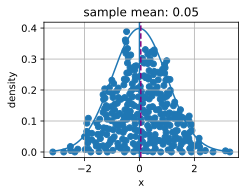

In [1]:
import random
from mxnet import np, npx
from d2l import mxnet as d2l

npx.set_np()

# Sample datapoints and create y coordinate
epsilon = 0.1
random.seed(8675309)
xs = np.random.normal(loc=0, scale=1, size=(300,))

ys = [np.sum(np.exp(-(xs[:i] - xs[i])**2 / (2 * epsilon**2))
             / np.sqrt(2*np.pi*epsilon**2)) / len(xs) for i in range(len(xs))]

# Compute true density
xd = np.arange(np.min(xs), np.max(xs), 0.01)
yd = np.exp(-xd**2/2) / np.sqrt(2 * np.pi)

# Plot the results
d2l.plot(xd, yd, 'x', 'density')
d2l.plt.scatter(xs, ys)
d2l.plt.axvline(x=0)
d2l.plt.axvline(x=np.mean(xs), linestyle='--', color='purple')
d2l.plt.title(f'sample mean: {float(np.mean(xs)):.2f}')
d2l.plt.show()

Pode haver muitas maneiras de calcular um estimador de um parâmetro $\hat{\theta}_n$. Nesta seção, apresentamos três métodos comuns para avaliar e comparar estimadores: o erro quadrático médio, o desvio padrão e o *bias* estatístico.

### Erro Quadrático Médio

Talvez a métrica mais simples usada para avaliar estimadores seja o *erro quadrático médio (EQM)* (ou perda $l_2$) de um estimador pode ser definido como

$$\mathrm{MSE} (\hat{\theta}_n, \theta) = E[(\hat{\theta}_n - \theta)^2].$$
:eqlabel:`eq_mse_est`

Isso nos permite quantificar o desvio médio quadrático do valor verdadeiro. MSE é sempre não negativo. Se você leu :numref:`sec_linear_regression`, você aoreconhecerá como a função de perda de regressão mais comumente usada. Como medida para avaliar um estimador, quanto mais próximo seu valor de zero, mais próximo o estimador está do verdadeiro parâmetro $\theta$.


### *Bias* Estatístico.

O EQM fornece uma métrica natural, mas podemos facilmente imaginar vários fenômenos diferentes que podem torná-lo grande. Dois fundamentalmente importantes são a flutuação no estimador devido à aleatoriedade no conjunto de dados e o erro sistemático no estimador devido ao procedimento de estimativa.


Primeiro, vamos medir o erro sistemático. Para um estimador $\hat{\theta}_n$, a ilustração matemática de *tendência estatística* pode ser definida como

$$\mathrm{bias}(\hat{\theta}_n) = E(\hat{\theta}_n - \theta) = E(\hat{\theta}_n) - \theta.$$
:eqlabel:`eq_bias`


Observe que quando $\mathrm{bias}(\hat{\theta}_n) = 0$, a expectativa do estimador \hat{\theta}_n$ é igual ao valor verdadeiro do parâmetro. Nesse caso, dizemos que $\hat{\theta}_n$ é um estimador imparcial. Em geral, um estimador não enviesado é melhor do que um estimador enviesado, pois sua expectativa é igual ao parâmetro verdadeiro.


É importante estar ciente, entretanto, que estimadores enviesados são frequentemente usados na prática. Há casos em que estimadores imparciais não existem sem suposições adicionais ou são intratáveis para calcular. Isso pode parecer uma falha significativa em um estimador, no entanto, a maioria dos estimadores encontrados na prática são pelo menos assintoticamente imparciais, no sentido de que o *bias* tende a zero enquanto o número de amostras disponíveis tende ao infinito: $\lim_{n \rightarrow \infty} \mathrm{bias}(\hat{\theta}_n) = 0$.


### Variância e Desvio Padrão

Em segundo lugar, vamos medir a aleatoriedade no estimador. Lembre-se de :numref:`sec_random_variables`, o *desvio padrão* (ou *erro padrão*) é definido como a raiz quadrada da variância. Podemos medir o grau de flutuação de um estimador medindo o desvio padrão ou a variância desse estimador.

$$\sigma_{\hat{\theta}_n} = \sqrt{\mathrm{Var} (\hat{\theta}_n )} = \sqrt{E[(\hat{\theta}_n - E(\hat{\theta}_n))^2]}.$$
:eqlabel:`eq_var_est`

É importante comparar :eqref:`eq_var_est` com :eqref: eq_mse_est`. Nesta equação, não comparamos com o valor real da população $\theta$ mas em vez disso com $E(\hat{\theta}_n)$, a média amostral esperada. Portanto, não estamos medindo o quão longe o estimador tende a estar do valor verdadeiro, mas sim medindo a flutuação do próprio estimador.


### The Bias-Variance Trade-off

É intuitivamente claro que esses dois componentes principais contribuem para o erro quadrático médio. O que é um tanto chocante é que podemos mostrar que isso é na verdade uma *decomposição* do erro quadrático médio nessas duas contribuições mais uma terceira. Isso quer dizer que podemos escrever o erro quadrático médio como a soma do quadrado da tendência, a variância e o erro irredutível.

$$
\begin{aligned}
\mathrm{MSE} (\hat{\theta}_n, \theta) &= E[(\hat{\theta}_n - \theta)^2] \\
 &= E[(\hat{\theta}_n)^2] + E[\theta^2] - 2E[\hat{\theta}_n\theta] \\
 &= \mathrm{Var} [\hat{\theta}_n] + E[\hat{\theta}_n]^2 + \mathrm{Var} [\theta] + E[\theta]^2 - 2E[\hat{\theta}_n]E[\theta] \\
 &= (E[\hat{\theta}_n] - E[\theta])^2 + \mathrm{Var} [\hat{\theta}_n] + \mathrm{Var} [\theta] \\
 &= (E[\hat{\theta}_n - \theta])^2 + \mathrm{Var} [\hat{\theta}_n] + \mathrm{Var} [\theta] \\
 &= (\mathrm{bias} [\hat{\theta}_n])^2 + \mathrm{Var} (\hat{\theta}_n) + \mathrm{Var} [\theta].\\
\end{aligned}
$$

Nós nos referimos à fórmula acima como *compensação de variação de polarização*. O erro quadrático médio pode ser dividido em três fontes de erro: o erro de alta polarização, o erro de alta variância e o erro irredutível. O erro de polarização é comumente visto em um modelo simples (como um modelo de regressão linear), que não pode extrair relações dimensionais altas entre os recursos e as saídas. Se um modelo sofre de erro de alta polarização, costumamos dizer que ele está *subaproveitado* ou falta de *flexibilidade* conforme apresentado em (:numref:`sec_model_selection`). A alta variação geralmente resulta de um modelo muito complexo, que supera os dados de treinamento. Como resultado, um modelo *overfitting* é sensível a pequenas flutuações nos dados. Se um modelo sofre de alta variância, costumamos dizer que está *sobreajuste* e falta de *generalização* conforme apresentado em (:numref:`sec_model_selection`). O erro irredutível é o resultado do ruído no próprio $\theta$.


### Avaliando estimadores em código

Uma vez que o desvio padrão de um estimador foi implementado simplesmente chamando `a.std ()` para um tensor `a`, vamos ignorá-lo, mas implementar o *bias* estatístico e o erro quadrático médio.


In [2]:
# Statistical bias
def stat_bias(true_theta, est_theta):
    return(np.mean(est_theta) - true_theta)

# Mean squared error
def mse(data, true_theta):
    return(np.mean(np.square(data - true_theta)))

Para ilustrar a equação do trade-off *bias*-variância, vamos simular a distribuição normal $\mathcal{N}(\theta, \sigma^2)$ com $10.000$ amostras. Aqui, usamos a $$\theta = 1$ e $\sigma = 4$. Como o estimador é uma função das amostras fornecidas, aqui usamos a média das amostras como um estimador para $\theta$ verdadeiros nesta distribuição normal $\mathcal{N}(\theta, \sigma^2)$ .


In [3]:
theta_true = 1
sigma = 4
sample_len = 10000
samples = np.random.normal(theta_true, sigma, sample_len)
theta_est = np.mean(samples)
theta_est

array(0.9503336)

Vamos validar a equação de trade-off calculando a soma da polarização quadrada e a variância de nosso estimador. Primeiro, calculamos o EQM de nosso estimador.


In [4]:
mse(samples, theta_true)

array(15.781996)

Em seguida, calculamos \mathrm{Var} (\hat{\theta}_n) + [\mathrm{bias} (\hat{\theta}_n)]^2$ como abaixo. Como você pode ver, os dois valores concordam com a precisão numérica.


In [5]:
bias = stat_bias(theta_true, theta_est)
np.square(samples.std()) + np.square(bias)

array(15.781995)

## Conducting Hypothesis Tests



O tópico mais comumente encontrado na inferência estatística é o teste de hipóteses. Embora o teste de hipóteses tenha sido popularizado no início do século 20, o primeiro uso pode ser rastreado até John Arbuthnot no século XVIII. John rastreou registros de nascimento de 80 anos em Londres e concluiu que mais homens nasciam do que mulheres a cada ano. Em seguida, o teste de significância moderno é a herança de inteligência de Karl Pearson que inventou o valor $p$ e o teste qui-quadrado de Pearson, William Gosset que é o pai da distribuição t de Student e Ronald Fisher que inicializou a hipótese nula e a teste de significância.

Um *teste de hipótese* é uma forma de avaliar algumas evidências contra a declaração padrão sobre uma população. Referimo-nos à declaração padrão como a *hipótese nula* $H_0$, que tentamos rejeitar usando os dados observados. Aqui, usamos $H_0$ como ponto de partida para o teste de significância estatística. A *hipótese alternativa* $H_A$ (ou $H_1$) é uma afirmação que é contrária à hipótese nula. Uma hipótese nula é freqüentemente afirmada em uma forma declarativa que postula uma relação entre variáveis. Deve refletir o resumo o mais explícito possível e ser testável pela teoria estatística.

Imagine que você é um químico. Depois de passar milhares de horas no laboratório, você desenvolve um novo medicamento que pode melhorar drasticamente a habilidade de entender matemática. Para mostrar seu poder mágico, você precisa testá-lo. Naturalmente, você pode precisar de alguns voluntários para tomar o remédio e ver se ele pode ajudá-los a aprender melhor a matemática. Como você começou?

Primeiro, você precisará de dois grupos de voluntários cuidadosamente selecionados aleatoriamente, para que não haja diferença entre sua capacidade de compreensão matemática medida por algumas métricas. Os dois grupos são comumente chamados de grupo de teste e grupo de controle. O *grupo de teste* (ou *grupo de tratamento*) é um grupo de indivíduos que experimentarão o medicamento, enquanto o *grupo de controle* representa o grupo de usuários que são separados como referência, ou seja, configurações de ambiente idênticas, exceto por tomar o medicamento. Desta forma, a influência de todas as variáveis ​​são minimizadas, exceto o impacto da variável independente no tratamento.

Em segundo lugar, após um período de tomar o medicamento, você precisará medir a compreensão matemática dos dois grupos pelas mesmas métricas, como permitir que os voluntários façam os mesmos testes depois de aprender uma nova fórmula matemática. Em seguida, você pode coletar seu desempenho e comparar os resultados. Nesse caso, nossa hipótese nula será que não há diferença entre os dois grupos, e nossa alternativa será que sim.

Isso ainda não é totalmente formal. Existem muitos detalhes nos quais você deve pensar cuidadosamente. Por exemplo, quais são as métricas adequadas para testar sua habilidade de compreensão matemática? Quantos voluntários para o seu teste, para que possa ter a certeza de afirmar a eficácia do seu medicamento? Por quanto tempo você deve executar o teste? Como você decide se há uma diferença entre os dois grupos? Você se preocupa apenas com o desempenho médio ou também com a faixa de variação das pontuações? E assim por diante.

Desta forma, o teste de hipótese fornece uma estrutura para o projeto experimental e raciocínio sobre a certeza nos resultados observados. Se pudermos agora mostrar que a hipótese nula é muito improvável de ser verdadeira, podemos rejeitá-la com confiança.

Para completar a história de como trabalhar com testes de hipóteses, precisamos agora introduzir alguma terminologia adicional e tornar alguns de nossos conceitos formais.


### Significância Estatística

A *significância estatística* mede a probabilidade de rejeitar erroneamente a hipótese nula, $H_0$, quando ela não deveria ser rejeitada, ou seja,

$$ \text{statistical significance }= 1 - \alpha = 1 - P(\text{reject } H_0 \mid H_0 \text{ is true} ).$$


Também é conhecido como *erro tipo I* ou *falso positivo*. O $\alpha$ é chamado de *nível de significância* e seu valor comumente usado é $5\%$, i.e., $1-\alpha = 95\%$. O nível de significância pode ser explicado como o nível de risco que estamos dispostos a correr, quando rejeitamos uma hipótese nula verdadeira.

:numref:`fig_statistically_significance` mostra os valores das observações e a probabilidade de uma dada distribuição normal em um teste de hipótese de duas amostras. Se o exemplo de dados de observação estiver localizado fora do limite de $95\%$, será uma observação muito improvável sob a hipótese de hipótese nula. Portanto, pode haver algo errado com a hipótese nula e nós a rejeitaremos.

![Significância Estatística.](../img/statistical-significance.svg)
:label:`fig_statistical_significance`


### Potência Estatística

A *potência estatística* (ou *sensibilidade*) mede a probabilidade de rejeitar a hipótese nula, $H_0$, quando deveria ser rejeitada, ou seja,

$$ \text{statistical power }= 1 - \beta = 1 - P(\text{ fail to reject } H_0  \mid H_0 \text{ is false} ).$$

Lembre-se de que um *erro tipo I* é causado pela rejeição da hipótese nula quando ela é verdadeira, enquanto um *erro tipo II* é resultado da falha em rejeitar a hipótese nula quando ela é falsa. Um erro do tipo II geralmente é denotado como $\beta e, portanto, o poder estatístico correspondente é $1-\beta$.



Intuitivamente, a potência estatística pode ser interpretada como a probabilidade de nosso teste detectar uma discrepância real de alguma magnitude mínima em um nível de significância estatística desejado. $80\%$ é um limite de poder estatístico comumente usado. Quanto maior o poder estatístico, maior será a probabilidade de detectarmos diferenças verdadeiras.

Um dos usos mais comuns do poder estatístico é determinar o número de amostras necessárias. A probabilidade de você rejeitar a hipótese nula quando ela é falsa depende do grau em que é falsa (conhecido como *tamanho do efeito*) e do número de amostras que você tem. Como você pode esperar, tamanhos de efeito pequenos exigirão um número muito grande de amostras para serem detectados com alta probabilidade. Embora além do escopo deste breve apêndice para derivar em detalhes, como um exemplo, queremos ser capazes de rejeitar uma hipótese nula de que nossa amostra veio de uma variância zero média gaussiana, e acreditamos que a média de nossa amostra está realmente perto de um , podemos fazer isso com taxas de erro aceitáveis ​​com um tamanho de amostra de apenas $8$. No entanto, se pensarmos que a média verdadeira de nossa amostra populacional está próxima de $0.01$, então precisaríamos de um tamanho de amostra de quase $80000$ para detectar a diferença.

Podemos imaginar o poder como um filtro de água. Nesta analogia, um teste de hipótese de alta potência é como um sistema de filtragem de água de alta qualidade que reduzirá as substâncias nocivas na água tanto quanto possível. Por outro lado, uma discrepância menor é como um filtro de água de baixa qualidade, onde algumas substâncias relativamente pequenas podem escapar facilmente das lacunas. Da mesma forma, se o poder estatístico não for suficientemente alto, o teste pode não detectar a discrepância menor.


### Estatística de Teste


Uma *estatística de teste* $T(x)$ é um escalar que resume algumas características dos dados de amostra. O objetivo de definir tal estatística é que ela deve nos permitir distinguir entre diferentes distribuições e conduzir nosso teste de hipótese. Voltando ao nosso exemplo químico, se quisermos mostrar que uma população tem um desempenho melhor do que a outra, pode ser razoável tomar a média como estatística de teste. Diferentes escolhas de estatísticas de teste podem levar a testes estatísticos com poder estatístico drasticamente diferente.

Frequentemente, $T(X)$ (a distribuição da estatística de teste sob nossa hipótese nula) seguirá, pelo menos aproximadamente, uma distribuição de probabilidade comum, como uma distribuição normal quando considerada sob a hipótese nula. Se pudermos derivar explicitamente essa distribuição e, em seguida, medir nossa estatística de teste em nosso conjunto de dados, podemos rejeitar com segurança a hipótese nula se nossa estatística estiver muito fora do intervalo que esperaríamos. Fazer esse quantitativo nos leva à noção de valores $p$.


### Valor $p$

O valor $p$ (ou o *valor de probabilidade*) é a probabilidade de que $T(X)$ seja pelo menos tão extremo quanto a estatística de teste observada $T(x)$ assumindo que a hipótese nula é *verdadeira*, ou seja,

$$ p\text{-value} = P_{H_0}(T(X) \geq T(x)).$$

Se o valor de $p$ for menor ou igual a um nível de significância estatística predefinido e fixo $\alpha$, podemos rejeitar a hipótese nula. Caso contrário, concluiremos que faltam evidências para rejeitar a hipótese nula. Para uma dada distribuição populacional, a *região de rejeição* será o intervalo contido de todos os pontos que possuem um valor $p$ menor que o nível de significância estatística $\alpha$.


### Teste unilateral e teste bilateral

Normalmente existem dois tipos de teste de significância: o teste unilateral e o teste bilateral. O *teste unilateral* é aplicável quando a hipótese nula e a hipótese alternativa têm apenas uma direção. Por exemplo, a hipótese nula pode afirmar que o parâmetro verdadeiro $\theta$ é menor ou igual a um valor $c$. A hipótese alternativa seria que $\theta$ é maior que $c$. Ou seja, a região de rejeição está em apenas um lado da distribuição da amostra. Ao contrário do teste unilateral, o *teste bilateral* é aplicável quando a região de rejeição está em ambos os lados da distribuição de amostragem. Um exemplo neste caso pode ter um estado de hipótese nula de que o parâmetro verdadeiro $\theta$ é igual a um valor $c$. A hipótese alternativa seria que $\theta$ não é igual a $ c $.


### Etapas Gerais de Teste de Hipóteses

Depois de se familiarizar com os conceitos acima, vamos passar pelas etapas gerais do teste de hipóteses.

1. Enuncie a questão e estabeleça uma hipótese nula $H_0$.
2. Defina o nível de significância estatística $\alpha$ e um poder estatístico ($1 - \beta$).
3. Obtenha amostras por meio de experimentos. O número de amostras necessárias dependerá do poder estatístico e do tamanho do efeito esperado.
4. Calcule a estatística de teste e o valor $p$.
5. Tome a decisão de manter ou rejeitar a hipótese nula com base no valor $p$ e no nível de significância estatística $\alpha$.


Para realizar um teste de hipótese, começamos definindo uma hipótese nula e um nível de risco que estamos dispostos a correr. Em seguida, calculamos a estatística de teste da amostra, tomando um valor extremo da estatística de teste como evidência contra a hipótese nula. Se a estatística de teste cair dentro da região de rejeição, podemos rejeitar a hipótese nula em favor da alternativa.

O teste de hipóteses é aplicável em uma variedade de cenários, como testes clínicos e testes A/B.


## Construindo Intervalos de Confiança



Ao estimar o valor de um parâmetro $\theta$, estimadores pontuais como $\hat \theta$ são de utilidade limitada, pois não contêm nenhuma noção de incerteza. Em vez disso, seria muito melhor se pudéssemos produzir um intervalo que contivesse o parâmetro verdadeiro $\theta$ com alta probabilidade. Se você estivesse interessado em tais ideias um século atrás, então você teria ficado animado ao ler "Esboço de uma teoria de estimativa estatística baseada na teoria clássica da probabilidade" por Jerzy Neyman :cite:`Neyman.1937`, que apresentou pela primeira vez o conceito de intervalo de confiança em 1937.

Para ser útil, um intervalo de confiança deve ser o menor possível para um determinado grau de certeza. Vamos ver como derivá-lo.


### Definição

Matematicamente, um *intervalo de confiança* para o parâmetro verdadeiro $\theta$ é um intervalo $C_n$ calculado a partir dos dados de amostra de modo que

$$P_{\theta} (C_n \ni \theta) \geq 1 - \alpha, \forall \theta.$$
:eqlabel:`eq_confidence`


Aqui, $\alpha \in (0, 1)$, e $1 - \alpha$ é chamado de *nível de confiança* ou *cobertura* do intervalo. Este é o mesmo $\alpha$ que o nível de significância discutido acima.

Observe que :eqref:`eq_confidence` é sobre a variável $C_n$, não sobre o $\theta$ fixo. Para enfatizar isso, escrevemos $P_{\theta} (C_n \ni \theta)$ em vez de $P_{\theta} (\theta \in C_n)$.

### Interpretação


É muito tentador interpretar um intervalo de confiança de $95\%$ como um intervalo em que você pode ter $95\%$ de certeza de que o parâmetro verdadeiro está, mas infelizmente isso não é verdade. O verdadeiro parâmetro é fixo e é o intervalo que é aleatório. Assim, uma interpretação melhor seria dizer que se você gerasse um grande número de intervalos de confiança por esse procedimento, $95\%$ dos intervalos gerados conteriam o parâmetro verdadeiro.

Isso pode parecer pedante, mas pode ter implicações reais para a interpretação dos resultados. Em particular, podemos satisfazer :eqref:`eq_confidence` construindo intervalos que estamos *quase certos* de que não contêm o valor verdadeiro, contanto que raramente o façamos o suficiente. Encerramos esta seção fornecendo três declarações tentadoras, mas falsas. Uma discussão aprofundada desses pontos pode ser encontrada em:cite:`Morey.Hoekstra.Rouder.ea.2016`.


* ** Falácia 1 **. Intervalos de confiança estreitos significam que podemos estimar o parâmetro com precisão.
* ** Falácia 2 **. Os valores dentro do intervalo de confiança têm mais probabilidade de ser o valor verdadeiro do que aqueles fora do intervalo.
* ** Falácia 3 **. A probabilidade de que um determinado intervalo de confiança de $95\%$ contenha o valor verdadeiro é de $95\%$.

Basta dizer que os intervalos de confiança são objetos sutis. No entanto, se você mantiver a interpretação clara, eles podem ser ferramentas poderosas.

### Um Exemplo Gaussiano

Vamos discutir o exemplo mais clássico, o intervalo de confiança para a média de uma Gaussiana de média e variância desconhecidas. Suponha que coletamos $n$ amostras $\{x_i\}_{i=1}^n$ de nossa gaussiana $\mathcal{N}(\mu, \sigma^2)$ Podemos calcular estimadores para a média e o desvio padrão tomando

$$\hat\mu_n = \frac{1}{n}\sum_{i=1}^n x_i \;\text{and}\; \hat\sigma^2_n = \frac{1}{n-1}\sum_{i=1}^n (x_i - \hat\mu)^2.$$

Se agora considerarmos a variável aleatória

$$
T = \frac{\hat\mu_n - \mu}{\hat\sigma_n/\sqrt{n}},
$$


obtemos uma variável aleatória seguindo uma distribuição bem *conhecida chamada *distribuição t de Student em* $n-1$ *graus de liberdade*.

Esta distribuição é muito bem estudada, e sabe-se, por exemplo, que como $n\rightarrow \infty$, é aproximadamente uma Gaussiana padrão e, portanto, observando os valores da Gaussiana f.d.c. em uma tabela, podemos concluir que o valor de $T$ está no intervalo $[-1.96, 1.96]$ pelo menos $95\%$ do tempo. Para valores finitos de $n$, o intervalo precisa ser um pouco maior, mas são bem conhecidos e pré-computados em tabelas.

Assim, podemos concluir que, para grandes $n$,

$$
P\left(\frac{\hat\mu_n - \mu}{\hat\sigma_n/\sqrt{n}} \in [-1.96, 1.96]\right) \ge 0.95.
$$

Reorganizando isso multiplicando ambos os lados por $\hat\sigma_n/\sqrt{n}$ e, em seguida, adicionando $\hat\mu_n$, obtemos

$$
P\left(\mu \in \left[\hat\mu_n - 1.96\frac{\hat\sigma_n}{\sqrt{n}}, \hat\mu_n + 1.96\frac{\hat\sigma_n}{\sqrt{n}}\right]\right) \ge 0.95.
$$

Assim, sabemos que encontramos nosso intervalo de confiança de $ 95 \% $:
$$\left[\hat\mu_n - 1.96\frac{\hat\sigma_n}{\sqrt{n}}, \hat\mu_n + 1.96\frac{\hat\sigma_n}{\sqrt{n}}\right].$$
:eqlabel:`eq_gauss_confidence`

É seguro dizer que :eqref:`eq_gauss_confidence` é uma das fórmulas mais usadas em estatística. Vamos encerrar nossa discussão sobre estatística implementando-a. Para simplificar, presumimos que estamos no regime assintótico. Valores pequenos de $N$ devem incluir o valor correto de `t_star` obtido tanto programaticamente quanto de uma tabela $t$.


In [6]:
# Number of samples
N = 1000

# Sample dataset
samples = np.random.normal(loc=0, scale=1, size=(N,))

# Lookup Students's t-distribution c.d.f.
t_star = 1.96

# Construct interval
mu_hat = np.mean(samples)
sigma_hat = samples.std(ddof=1)
(mu_hat - t_star*sigma_hat/np.sqrt(N), mu_hat + t_star*sigma_hat/np.sqrt(N))

(array(-0.07853346), array(0.04412608))

## Resumo

* Estatísticas se concentram em problemas de inferência, enquanto o *deep learning* enfatiza em fazer previsões precisas sem programação e compreensão explícitas.
* Existem três métodos comuns de inferência estatística: avaliação e comparação de estimadores, realização de testes de hipótese e construção de intervalos de confiança.
* Existem três estimadores mais comuns: tendência estatística, desvio padrão e erro quadrático médio.
* Um intervalo de confiança é um intervalo estimado de um parâmetro populacional verdadeiro que podemos construir com base nas amostras.
* O teste de hipóteses é uma forma de avaliar algumas evidências contra a declaração padrão sobre uma população.


## Exercícios

1. Seja $X_1, X_2, \ldots, X_n \overset{\text{idfi}}{\sim} \mathrm{Unif}(0, \theta)$, onde "idfi" significa *independente e distribuído de forma idêntica* . Considere os seguintes estimadores de $\theta$:
$$\hat{\theta} = \max \{X_1, X_2, \ldots, X_n \};$$
$$\tilde{\theta} = 2 \bar{X_n} = \frac{2}{n} \sum_{i=1}^n X_i.$$
    * Encontre a tendência estatística, o desvio padrão e o erro quadrático médio de $\hat{\theta}.$
    * Encontre o viés estatístico, o desvio padrão e o erro quadrático médio de $\tilde{\theta}.$
    * Qual estimador é melhor?
1. Para nosso exemplo de químico na introdução, você pode derivar as 5 etapas para conduzir um teste de hipótese bilateral? Dado o nível de significância estatística $\alpha = 0.05$ e a potência estatística $1 - \beta = 0.8$.
1. Execute o código do intervalo de confiança com $N=2$ e $\alpha = 0.5$ para $100$ conjunto de dados gerado independentemente e plote os intervalos resultantes (neste caso `t_star = 1.0`). Você verá vários intervalos muito curtos que estão longe de conter a verdadeira média $0$. Isso contradiz a interpretação do intervalo de confiança? Você se sente confortável usando intervalos curtos para indicar estimativas de alta precisão?


[Discussões](https://discuss.d2l.ai/t/419)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTEzNjY4NTM2ODgsNzE5NDk2NzQ0LDE4NT
A3ODIyMjgsLTEyMjU3NDcxNjEsMTQxNDkyMzAxNiwxOTQ5NTQ2
NzI3XX0=
-->
